Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.6 MB/s 
     |████████████████████████████████| 101 kB 9.4 MB/s 
     |████████████████████████████████| 596 kB 75.5 MB/s 
     |████████████████████████████████| 6.6 MB 46.1 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=bfdc881407ffbb6701df78d70efdb9894c17e939ca33e68fc9991f9f5d3dc3b3
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1KL35Y4jz-za4VhiYyi9-wDsYb-_ES9Lg'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1IdJeCCcjeLt1H8vJNgWmgTFFfSnCUfZY'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '1J4zNlfBAd1ng4GfyBabBM2EGjKreruBa'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  2253
Number of dev sentences:  138
Number of test sentences:  182
Number of words in the training dataset:  5994
Number of words in the dev dataset:  1008
Number of words in the test dataset:  1171
Tags in the training dataset: ['B-Number', 'I-Property-Type', 'B-Meta', 'B-Material', 'I-Property-Misc', 'B-Brand', 'I-Operation', 'B-Property-Misc', 'B-Characterization-Apparatus', 'B-Nonrecipe-Material', 'B-Reference', 'I-Amount-Unit', 'I-Nonrecipe-Material', 'B-Property-Unit', 'I-Apparatus-Unit', 'I-Synthesis-Apparatus', 'B-Condition-Unit', 'I-Apparatus-Descriptor', 'B-Material-Descriptor', 'I-Material-Descriptor', 'I-Reference', 'B-Apparatus-Descriptor', 'B-Amount-Unit', 'B-Condition-Type', 'I-Condition-Unit', 'I-Apparatus-Property-Type', 'O', 'B-Amount-Misc', 'I-Characterization-Apparatus', 'I-Amount-Misc', 'I-Condition-Misc', 'B-Condition-Misc', 'I-Condition-Type', 'I-Number', 'B-Property-Type', 'B-Synthesis-Apparatus', 'B-Apparatus-Unit', 'I-Material', '

,Sentence #,Word,Tag
0,Sentence: 1,10.1016,O
1,Sentence: 1,/,O
2,Sentence: 1,j.carbon.2014.03.017,O
3,Sentence: 2,High,B-Property-Misc
4,Sentence: 2,-,I-Property-Misc
5,Sentence: 2,capacity,I-Property-Misc
6,Sentence: 2,graphene,B-Material
7,Sentence: 2,oxide,I-Material
8,Sentence: 2,/,I-Material
9,Sentence: 2,graphite,I-Material


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #100 
training_sentences[100]

[('The', 'O'),
 ('obtained', 'O'),
 ('precursor', 'B-Material'),
 ('powder', 'B-Material-Descriptor'),
 ('was', 'O'),
 ('dried', 'B-Operation'),
 ('at', 'O'),
 ('120', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('and', 'O'),
 ('then', 'O'),
 ('calcined', 'B-Operation'),
 ('at', 'O'),
 ('700', 'B-Number'),
 ('degC', 'B-Condition-Unit'),
 ('for', 'O'),
 ('2', 'B-Number'),
 ('h', 'B-Condition-Unit'),
 ('.', 'O')]

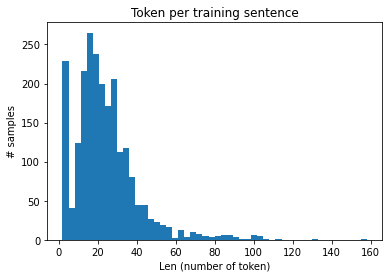

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

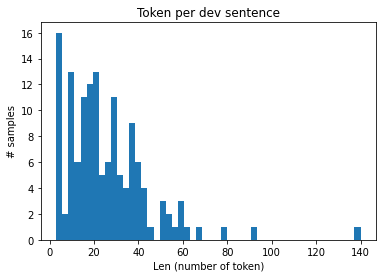

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

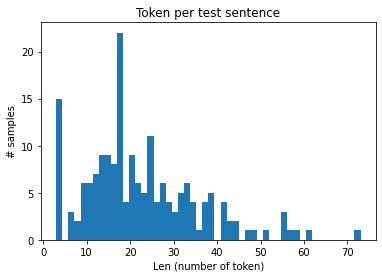

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'ethanol'
print(word2idx['ethanol'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Material'
print(tag2idx['B-Material'])
# Tag of index 4
print(idx2tag[4])

393
active
3
I-Property-Misc


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.25)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 2253
Points in y_train before removal: 2253
Points in X_train before removal: 1690
Points in y_train before removal: 1690


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[4900, 3145, 1725, 3013, 1674, 1441, 1184, 5988, 1425, 2016, 3709, 2104, 1725, 5107, 1253, 6281, 1051, 4823, 5146, 3565, 3120, 589, 1725, 1724, 1915, 1184, 6480, 2816, 3093, 2209, 3120, 3852, 1725, 2399, 1415]
[0, 22, 26, 3, 37, 37, 26, 31, 40, 26, 0, 22, 26, 27, 3, 26, 0, 16, 26, 26, 26, 16, 26, 26, 3, 26, 40, 26, 0, 26, 26, 40, 26, 3, 26]
[625, 1674, 1930]
[26, 26, 26]
[625, 1674, 1847]
[26, 26, 26]
393
active
3
I-Property-Misc
6535
43


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1k9ffQhdSi8nv1s9hV8jNBguR4m4FIZWp'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['ethanol'])
print(idx2word[10])
print(tag2idx['B-Material'])
print(idx2tag[4])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 13.6 MB/s 
     |████████████████████████████████| 6.6 MB 38.8 MB/s 
     |████████████████████████████████| 120 kB 61.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.6 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=a82c3db4daa68f9f9091b72a32fd0c7f6297415096a0237cd1b5157f2321abf3
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[4900, 3145, 1725, 3013, 1674, 1441, 1184, 5988, 1425, 201

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 32:
    TRAIN_BATCH_SIZE = 32
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 32:
    VALID_BATCH_SIZE = 32
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 1690
Points in y_train after augmentation: 1690
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.530789375305176
Training loss epoch: 1.0017768431384608
Training accuracy epoch: 0.764790963353861
Validating model...
Validation Loss: 0.5286266952753067
Validation Accuracy: 0.8548120377605624
Training epoch: 2
Training loss per 100 training steps: 0.44244372844696045
Training loss epoch: 0.40158904554708946
Training accuracy epoch: 0.8821922281434948
Validating model...
Validation Loss: 0.4456442385911942
Validation Accuracy: 0.8613571549010823
Training epoch: 3
Training loss per 100 training steps: 0.28950533270835876
Training loss epoch: 0.2748131212198509
Training accuracy epoch: 0.9127141962004832
Validating model...
Validation Loss: 0.44382544457912443
Validation Accuracy: 0.8668784605066477
Training epoch: 4
Training loss per 100 training steps: 0.1429159939289093
Training loss epoch: 0.18674658843368855
Training accuracy epoch: 0.9429170132767497
Validating model...
Validation Loss: 0.47230600118637084
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4786995053291321
Validation Accuracy: 0.8514186646918428
Validation duration: 0.011196116666666475 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.50      0.67      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.59      0.81      0.69        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.51      1.00      0.68        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.76      0.90      0.83       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8580069541931152
Training loss epoch: 1.0509527865445838
Training accuracy epoch: 0.7579180734160949
Validating model...
Validation Loss: 0.5748619675636292
Validation Accuracy: 0.840131750841967
Training epoch: 2
Training loss per 100 training steps: 0.39931896328926086
Training loss epoch: 0.41965716402485687
Training accuracy epoch: 0.8796023437703862
Validating model...
Validation Loss: 0.4625310003757477
Validation Accuracy: 0.8593274690083502
Training epoch: 3
Training loss per 100 training steps: 0.3075824975967407
Training loss epoch: 0.2921363739472515
Training accuracy epoch: 0.9109504638622169
Validating model...
Validation Loss: 0.4852164417505264
Validation Accuracy: 0.8653223739534445
Training epoch: 4
Training loss per 100 training steps: 0.22679607570171356
Training loss epoch: 0.20400491441195867
Training accuracy epoch: 0.9359342151155684
Validating model...
Validation Loss: 0.4575864911079407
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5194366734761459
Validation Accuracy: 0.8495367390842758
Validation duration: 0.011160933333333864 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.97      0.95      0.96        98
      Apparatus-Descriptor       0.54      0.78      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.45      0.90      0.60        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.75      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 4.041164875030518
Training loss epoch: 1.0636593131524212
Training accuracy epoch: 0.7520441695139277
Validating model...
Validation Loss: 0.566541588306427
Validation Accuracy: 0.839279981688664
Training epoch: 2
Training loss per 100 training steps: 0.587022602558136
Training loss epoch: 0.41554063671040087
Training accuracy epoch: 0.8789418299609687
Validating model...
Validation Loss: 0.45072019994258883
Validation Accuracy: 0.8620287669839835
Training epoch: 3
Training loss per 100 training steps: 0.37643590569496155
Training loss epoch: 0.28976380122157763
Training accuracy epoch: 0.9098627429045338
Validating model...
Validation Loss: 0.4284640148282051
Validation Accuracy: 0.8657217970754157
Training epoch: 4
Training loss per 100 training steps: 0.28732654452323914
Training loss epoch: 0.20093647840450396
Training accuracy epoch: 0.9368873780609603
Validating model...
Validation Loss: 0.511967471241951
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47005605926880467
Validation Accuracy: 0.8483204935959276
Validation duration: 0.011233199999999973 minutes
F1-score (test): 77.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.23      0.43      0.30         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.50      0.78      0.61         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.43      0.27      0.33        11
            Condition-Misc       0.60      0.90      0.72        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.90      0.97      0.93        87
                  Material       0.75      0.85      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.657081365585327
Training loss epoch: 1.0062373820340857
Training accuracy epoch: 0.7646586599168121
Validating model...
Validation Loss: 0.5715359807014465
Validation Accuracy: 0.8348148204119725
Training epoch: 2
Training loss per 100 training steps: 0.46228259801864624
Training loss epoch: 0.40930655851679026
Training accuracy epoch: 0.8810420780482274
Validating model...
Validation Loss: 0.4554699182510376
Validation Accuracy: 0.8594343092771416
Training epoch: 3
Training loss per 100 training steps: 0.37161654233932495
Training loss epoch: 0.2829053084243019
Training accuracy epoch: 0.9136885366320646
Validating model...
Validation Loss: 0.4299231141805649
Validation Accuracy: 0.8619710887126917
Training epoch: 4
Training loss per 100 training steps: 0.18192245066165924
Training loss epoch: 0.19491143440300562
Training accuracy epoch: 0.9381373868068522
Validating model...
Validation Loss: 0.45338270366191863
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45687989546702457
Validation Accuracy: 0.8578583650461012
Validation duration: 0.011238499999999855 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.61      0.85      0.71        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.54      0.95      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.87      0.98      0.92        87
                  Material       0.75      0.89      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.8536324501037598
Training loss epoch: 1.0462674470442646
Training accuracy epoch: 0.7591459723820557
Validating model...
Validation Loss: 0.5764314860105515
Validation Accuracy: 0.8392711910084468
Training epoch: 2
Training loss per 100 training steps: 0.5492873191833496
Training loss epoch: 0.4310662791414081
Training accuracy epoch: 0.8762749448935134
Validating model...
Validation Loss: 0.42704588174819946
Validation Accuracy: 0.8641719661012296
Training epoch: 3
Training loss per 100 training steps: 0.2920968532562256
Training loss epoch: 0.3101277028052312
Training accuracy epoch: 0.9043261952233057
Validating model...
Validation Loss: 0.4215453714132309
Validation Accuracy: 0.8636505827564456
Training epoch: 4
Training loss per 100 training steps: 0.1600228101015091
Training loss epoch: 0.21935986488495232
Training accuracy epoch: 0.928970159178823
Validating model...
Validation Loss: 0.41345146149396894
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4605255677149846
Validation Accuracy: 0.8563851002494783
Validation duration: 0.0116169333333346 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.87      0.92      0.90        98
      Apparatus-Descriptor       0.67      0.89      0.76         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.71      0.74      0.73        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.47      0.95      0.63        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.76      0.86      0.81       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from th

Training epoch: 1
Training loss per 100 training steps: 3.7226579189300537
Training loss epoch: 1.0644121777336553
Training accuracy epoch: 0.7532638468532044
Validating model...
Validation Loss: 0.5875639349222184
Validation Accuracy: 0.8372134357962121
Training epoch: 2
Training loss per 100 training steps: 0.40309688448905945
Training loss epoch: 0.45290903943889543
Training accuracy epoch: 0.8673072234853518
Validating model...
Validation Loss: 0.43644324541091917
Validation Accuracy: 0.8641983678968062
Training epoch: 3
Training loss per 100 training steps: 0.4446943998336792
Training loss epoch: 0.311243066810212
Training accuracy epoch: 0.9048019525510973
Validating model...
Validation Loss: 0.4286184161901474
Validation Accuracy: 0.8584000856390552
Training epoch: 4
Training loss per 100 training steps: 0.254330575466156
Training loss epoch: 0.24111683835398476
Training accuracy epoch: 0.9222243355548327
Validating model...
Validation Loss: 0.41785713732242585
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4748025777248236
Validation Accuracy: 0.8491270774073711
Validation duration: 0.011225949999999329 minutes
F1-score (test): 76.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.58      0.78      0.67        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.05      1.00      0.10         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.74      0.90      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.976041078567505
Training loss epoch: 1.0342976119158402
Training accuracy epoch: 0.7584096598976758
Validating model...
Validation Loss: 0.5667615413665772
Validation Accuracy: 0.8374267082124115
Training epoch: 2
Training loss per 100 training steps: 0.5606490969657898
Training loss epoch: 0.4131916294682701
Training accuracy epoch: 0.8808792157146375
Validating model...
Validation Loss: 0.46333284974098204
Validation Accuracy: 0.8622522599110634
Training epoch: 3
Training loss per 100 training steps: 0.3689381778240204
Training loss epoch: 0.28482113469321774
Training accuracy epoch: 0.9126733432478806
Validating model...
Validation Loss: 0.5059895694255829
Validation Accuracy: 0.856917050664434
Training epoch: 4
Training loss per 100 training steps: 0.22087234258651733
Training loss epoch: 0.1980988211789221
Training accuracy epoch: 0.9368481837687308
Validating model...
Validation Loss: 0.4731359273195267
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4751907770450299
Validation Accuracy: 0.8512789711047989
Validation duration: 0.011284800000000435 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.80      0.74      0.77        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.59      0.95      0.73        20
            Condition-Type       0.14      1.00      0.25         1
            Condition-Unit       0.89      0.95      0.92        87
                  Material       0.69      0.90      0.78       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.822970151901245
Training loss epoch: 1.030562843916551
Training accuracy epoch: 0.7618802869547733
Validating model...
Validation Loss: 0.6217217385768891
Validation Accuracy: 0.8277386828583877
Training epoch: 2
Training loss per 100 training steps: 0.5096448659896851
Training loss epoch: 0.4416198468995544
Training accuracy epoch: 0.8759932010604002
Validating model...
Validation Loss: 0.45677185952663424
Validation Accuracy: 0.8686621043900449
Training epoch: 3
Training loss per 100 training steps: 0.46526432037353516
Training loss epoch: 0.311799666791592
Training accuracy epoch: 0.9033120540715821
Validating model...
Validation Loss: 0.41693764477968215
Validation Accuracy: 0.8685130662894164
Training epoch: 4
Training loss per 100 training steps: 0.25053295493125916
Training loss epoch: 0.23401512036908348
Training accuracy epoch: 0.9256879214835748
Validating model...
Validation Loss: 0.4218526780605316
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46846352173731876
Validation Accuracy: 0.8565521534853635
Validation duration: 0.01140911666666587 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.57      1.00      0.73        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.88      0.98      0.92        87
                  Material       0.74      0.89      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.964592456817627
Training loss epoch: 1.0649051593159728
Training accuracy epoch: 0.7543689551413052
Validating model...
Validation Loss: 0.6196341067552567
Validation Accuracy: 0.8299135438185197
Training epoch: 2
Training loss per 100 training steps: 0.3533816933631897
Training loss epoch: 0.44044371427230117
Training accuracy epoch: 0.8766589790238506
Validating model...
Validation Loss: 0.47135753333568575
Validation Accuracy: 0.8586333439325331
Training epoch: 3
Training loss per 100 training steps: 0.34464260935783386
Training loss epoch: 0.3194208277283974
Training accuracy epoch: 0.9029711282539558
Validating model...
Validation Loss: 0.42370213121175765
Validation Accuracy: 0.8649725051870796
Training epoch: 4
Training loss per 100 training steps: 0.2559909224510193
Training loss epoch: 0.23602548185384498
Training accuracy epoch: 0.9259228175473859
Validating model...
Validation Loss: 0.4754118800163269
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.461510202059379
Validation Accuracy: 0.8556516089067965
Validation duration: 0.011467616666667861 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.58      0.78      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.74      0.88      0.81       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are 

Training epoch: 1
Training loss per 100 training steps: 3.6973254680633545
Training loss epoch: 1.009115847776521
Training accuracy epoch: 0.765508448283023
Validating model...
Validation Loss: 0.5754282593727111
Validation Accuracy: 0.8433463417561706
Training epoch: 2
Training loss per 100 training steps: 0.35591885447502136
Training loss epoch: 0.41714399828101106
Training accuracy epoch: 0.8784167099962824
Validating model...
Validation Loss: 0.43564108312129973
Validation Accuracy: 0.8663600008999701
Training epoch: 3
Training loss per 100 training steps: 0.26961153745651245
Training loss epoch: 0.2905593936173421
Training accuracy epoch: 0.9097773067799296
Validating model...
Validation Loss: 0.42249192446470263
Validation Accuracy: 0.8634594639165558
Training epoch: 4
Training loss per 100 training steps: 0.2908194959163666
Training loss epoch: 0.2047884427713898
Training accuracy epoch: 0.9348157979282288
Validating model...
Validation Loss: 0.4623608529567719
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4488319479502164
Validation Accuracy: 0.8582942746502995
Validation duration: 0.011427083333334547 minutes
F1-score (test): 78.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.92      0.93      0.92        98
      Apparatus-Descriptor       0.62      0.56      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.50      0.63      0.56        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.51      0.95      0.67        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.77      0.84      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.560767650604248
Training loss epoch: 0.9254361475581554
Training accuracy epoch: 0.7799669501280904
Validating model...
Validation Loss: 0.5083673238754273
Validation Accuracy: 0.8520459894117887
Training epoch: 2
Training loss per 100 training steps: 0.37584352493286133
Training loss epoch: 0.3977681854322775
Training accuracy epoch: 0.8829047008235009
Validating model...
Validation Loss: 0.45527124404907227
Validation Accuracy: 0.8672245296457675
Training epoch: 3
Training loss per 100 training steps: 0.40129896998405457
Training loss epoch: 0.2749356192939762
Training accuracy epoch: 0.9133459457434114
Validating model...
Validation Loss: 0.4188783824443817
Validation Accuracy: 0.8660976903829765
Training epoch: 4
Training loss per 100 training steps: 0.18303442001342773
Training loss epoch: 0.18507116390809195
Training accuracy epoch: 0.9420174976088221
Validating model...
Validation Loss: 0.43382653743028643
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47651907343130845
Validation Accuracy: 0.848002205214568
Validation duration: 0.011587633333332785 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.95      0.96      0.95        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.70      0.78      0.74        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.54      1.00      0.70        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.76      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.865821123123169
Training loss epoch: 0.9290010964692529
Training accuracy epoch: 0.780995826735444
Validating model...
Validation Loss: 0.5550644874572754
Validation Accuracy: 0.8531582129746891
Training epoch: 2
Training loss per 100 training steps: 0.43899697065353394
Training loss epoch: 0.3920820394336288
Training accuracy epoch: 0.8865591923218631
Validating model...
Validation Loss: 0.4220788091421127
Validation Accuracy: 0.8712101946945483
Training epoch: 3
Training loss per 100 training steps: 0.2205919474363327
Training loss epoch: 0.26230768314493236
Training accuracy epoch: 0.9189894474367889
Validating model...
Validation Loss: 0.42517468631267546
Validation Accuracy: 0.8657362318670891
Training epoch: 4
Training loss per 100 training steps: 0.22353821992874146
Training loss epoch: 0.19109738240046287
Training accuracy epoch: 0.9397838400114675
Validating model...
Validation Loss: 0.41997732818126676
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5071573910804895
Validation Accuracy: 0.8562287906903279
Validation duration: 0.011493116666667903 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.42      0.71      0.53         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.68      0.85      0.75        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.50      0.95      0.66        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.77      0.86      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.856934070587158
Training loss epoch: 0.9368220111216182
Training accuracy epoch: 0.7748393472238273
Validating model...
Validation Loss: 0.4996230274438858
Validation Accuracy: 0.8555094688163543
Training epoch: 2
Training loss per 100 training steps: 0.36427387595176697
Training loss epoch: 0.3884160178365992
Training accuracy epoch: 0.8838862991788026
Validating model...
Validation Loss: 0.41377316415309906
Validation Accuracy: 0.8764207442069228
Training epoch: 3
Training loss per 100 training steps: 0.24194906651973724
Training loss epoch: 0.26638032295810643
Training accuracy epoch: 0.9152559501139003
Validating model...
Validation Loss: 0.4328930303454399
Validation Accuracy: 0.8707322989806018
Training epoch: 4
Training loss per 100 training steps: 0.18668118119239807
Training loss epoch: 0.19469633887508023
Training accuracy epoch: 0.9386969654227121
Validating model...
Validation Loss: 0.4447730004787445
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45761112524912906
Validation Accuracy: 0.854687349241671
Validation duration: 0.011538800000001478 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.62      0.89      0.73        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.76      0.86      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8534164428710938
Training loss epoch: 0.9369791603800076
Training accuracy epoch: 0.7800881649137322
Validating model...
Validation Loss: 0.504680746793747
Validation Accuracy: 0.860952663367776
Training epoch: 2
Training loss per 100 training steps: 0.5653181672096252
Training loss epoch: 0.38908784046991546
Training accuracy epoch: 0.8837818439125927
Validating model...
Validation Loss: 0.43365158438682555
Validation Accuracy: 0.8644678894511493
Training epoch: 3
Training loss per 100 training steps: 0.24345339834690094
Training loss epoch: 0.38080750828358667
Training accuracy epoch: 0.9003767736399712
Validating model...
Validation Loss: 0.43563519418239594
Validation Accuracy: 0.8663656513396237
Training epoch: 4
Training loss per 100 training steps: 0.19089756906032562
Training loss epoch: 0.21573115951979338
Training accuracy epoch: 0.9365768990322354
Validating model...
Validation Loss: 0.4211971998214722
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49543664088616
Validation Accuracy: 0.8596970351155874
Validation duration: 0.011507349999999406 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.57      0.89      0.70         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.58      0.78      0.67        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.49      1.00      0.66        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.75      0.85      0.80       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.822902202606201
Training loss epoch: 0.9569177801039681
Training accuracy epoch: 0.7728849448380887
Validating model...
Validation Loss: 0.5710329979658126
Validation Accuracy: 0.8434107112668311
Training epoch: 2
Training loss per 100 training steps: 0.4599916338920593
Training loss epoch: 0.38560086444242675
Training accuracy epoch: 0.8859759595554861
Validating model...
Validation Loss: 0.42972054034471513
Validation Accuracy: 0.8710149994148833
Training epoch: 3
Training loss per 100 training steps: 0.16473376750946045
Training loss epoch: 0.2530932031022802
Training accuracy epoch: 0.9208613906197323
Validating model...
Validation Loss: 0.43492709547281266
Validation Accuracy: 0.8732379192202258
Training epoch: 4
Training loss per 100 training steps: 0.2599940001964569
Training loss epoch: 0.16925823299297646
Training accuracy epoch: 0.9484204320765011
Validating model...
Validation Loss: 0.45274732261896133
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4702813717035147
Validation Accuracy: 0.8548964716087405
Validation duration: 0.011470183333331836 minutes
F1-score (test): 77.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.89      0.95      0.92        98
      Apparatus-Descriptor       0.32      0.89      0.47         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.59      0.74      0.66        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.59      1.00      0.74        20
            Condition-Type       0.08      1.00      0.15         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.73      0.85      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7294750213623047
Training loss epoch: 0.938633005120861
Training accuracy epoch: 0.7755497543878284
Validating model...
Validation Loss: 0.5361292481422424
Validation Accuracy: 0.851288035877881
Training epoch: 2
Training loss per 100 training steps: 0.44124507904052734
Training loss epoch: 0.39724663211338557
Training accuracy epoch: 0.8806151126819806
Validating model...
Validation Loss: 0.45832045674324035
Validation Accuracy: 0.8717865398173977
Training epoch: 3
Training loss per 100 training steps: 0.3228949010372162
Training loss epoch: 0.3244085262960462
Training accuracy epoch: 0.8992451904845383
Validating model...
Validation Loss: 0.4488601326942444
Validation Accuracy: 0.8645124752370797
Training epoch: 4
Training loss per 100 training steps: 0.2635515034198761
Training loss epoch: 0.25721800638668574
Training accuracy epoch: 0.9177032199365674
Validating model...
Validation Loss: 0.4292822897434235
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4956759443649879
Validation Accuracy: 0.8484967831757532
Validation duration: 0.011409233333332243 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.56      0.70      0.62        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.55      0.85      0.67        20
            Condition-Type       0.20      1.00      0.33         1
            Condition-Unit       0.94      0.90      0.92        87
                  Material       0.74      0.88      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8471715450286865
Training loss epoch: 0.9350464183892777
Training accuracy epoch: 0.7767927555633555
Validating model...
Validation Loss: 0.5231633245944977
Validation Accuracy: 0.8449360921636634
Training epoch: 2
Training loss per 100 training steps: 0.41064247488975525
Training loss epoch: 0.3884591006520969
Training accuracy epoch: 0.8867715241513179
Validating model...
Validation Loss: 0.4176895424723625
Validation Accuracy: 0.8697573689326923
Training epoch: 3
Training loss per 100 training steps: 0.29680895805358887
Training loss epoch: 0.2678341249476618
Training accuracy epoch: 0.9166998006174912
Validating model...
Validation Loss: 0.43465940952301024
Validation Accuracy: 0.8667483102746513
Training epoch: 4
Training loss per 100 training steps: 0.21670691668987274
Training loss epoch: 0.19984536738232223
Training accuracy epoch: 0.9381422470585157
Validating model...
Validation Loss: 0.4552782565355301
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47888466028066784
Validation Accuracy: 0.8517710591262037
Validation duration: 0.011531416666662153 minutes
F1-score (test): 76.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.11      0.14      0.12         7
               Amount-Unit       0.85      0.95      0.90        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.45      0.45      0.45        11
            Condition-Misc       0.49      0.95      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.97      0.92        87
                  Material       0.71      0.86      0.78       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6615121364593506
Training loss epoch: 0.8973304865075581
Training accuracy epoch: 0.7857558669653271
Validating model...
Validation Loss: 0.4802967458963394
Validation Accuracy: 0.8669350600975555
Training epoch: 2
Training loss per 100 training steps: 0.3930554986000061
Training loss epoch: 0.38520335706312264
Training accuracy epoch: 0.8890294038504233
Validating model...
Validation Loss: 0.45369034111499784
Validation Accuracy: 0.8602503951071601
Training epoch: 3
Training loss per 100 training steps: 0.31585514545440674
Training loss epoch: 0.260801862758487
Training accuracy epoch: 0.9194647951918936
Validating model...
Validation Loss: 0.4325580507516861
Validation Accuracy: 0.8657648815237184
Training epoch: 4
Training loss per 100 training steps: 0.1351206749677658
Training loss epoch: 0.16784952180251592
Training accuracy epoch: 0.9473061999354325
Validating model...
Validation Loss: 0.465644171833992
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4758484913752629
Validation Accuracy: 0.850455799428858
Validation duration: 0.011514499999998406 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.54      0.70      0.61        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.75      0.91      0.82       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.854811668395996
Training loss epoch: 0.941480595229277
Training accuracy epoch: 0.7771064067651319
Validating model...
Validation Loss: 0.5138439357280731
Validation Accuracy: 0.8505049675305619
Training epoch: 2
Training loss per 100 training steps: 0.3864264190196991
Training loss epoch: 0.4019319775389202
Training accuracy epoch: 0.8819859454171
Validating model...
Validation Loss: 0.4274234265089035
Validation Accuracy: 0.8660574887180464
Training epoch: 3
Training loss per 100 training steps: 0.35235661268234253
Training loss epoch: 0.2753727682935658
Training accuracy epoch: 0.9134866387358465
Validating model...
Validation Loss: 0.43310163021087644
Validation Accuracy: 0.8710186764140199
Training epoch: 4
Training loss per 100 training steps: 0.17034702003002167
Training loss epoch: 0.20175811114595898
Training accuracy epoch: 0.9385132348313392
Validating model...
Validation Loss: 0.4238405868411064
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5067708171330966
Validation Accuracy: 0.8591902834934039
Validation duration: 0.011586816666666284 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.31      0.57      0.40         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.75      0.86      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2113
Points in y_train after augmentation: 2113
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.87203311920166
Training loss epoch: 0.9661275802263573
Training accuracy epoch: 0.7689009633649178
Validating model...
Validation Loss: 0.5377310574054718
Validation Accuracy: 0.8501729118703224
Training epoch: 2
Training loss per 100 training steps: 0.37360480427742004
Training loss epoch: 0.4049264005760648
Training accuracy epoch: 0.8807078665368007
Validating model...
Validation Loss: 0.44437962472438813
Validation Accuracy: 0.8591013238291394
Training epoch: 3
Training loss per 100 training steps: 0.2931882441043854
Training loss epoch: 0.2784116935374132
Training accuracy epoch: 0.9152606094626808
Validating model...
Validation Loss: 0.4950176000595093
Validation Accuracy: 0.8551685574474636
Training epoch: 4
Training loss per 100 training steps: 0.13713978230953217
Training loss epoch: 0.1985736901579953
Training accuracy epoch: 0.9383886751549136
Validating model...
Validation Loss: 0.4127883598208427
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46520890868627107
Validation Accuracy: 0.8622843521083655
Validation duration: 0.011380099999996673 minutes
F1-score (test): 78.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.92      0.95      0.93        98
      Apparatus-Descriptor       0.60      0.67      0.63         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.79      0.81      0.80        27
Characterization-Apparatus       0.62      0.45      0.53        11
            Condition-Misc       0.60      0.90      0.72        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.89      0.95      0.92        87
                  Material       0.74      0.85      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.985396146774292
Training loss epoch: 0.8992811273783445
Training accuracy epoch: 0.7841416092921388
Validating model...
Validation Loss: 0.48646890223026273
Validation Accuracy: 0.8522120703500393
Training epoch: 2
Training loss per 100 training steps: 0.4319533407688141
Training loss epoch: 0.3568581709638238
Training accuracy epoch: 0.8914141924725294
Validating model...
Validation Loss: 0.40367633402347564
Validation Accuracy: 0.8761766404614727
Training epoch: 3
Training loss per 100 training steps: 0.29938703775405884
Training loss epoch: 0.22843741336837411
Training accuracy epoch: 0.929199603763039
Validating model...
Validation Loss: 0.4054083302617073
Validation Accuracy: 0.8773019906954584
Training epoch: 4
Training loss per 100 training steps: 0.16151680052280426
Training loss epoch: 0.1493016810156405
Training accuracy epoch: 0.9543285983059644
Validating model...
Validation Loss: 0.4487784385681152
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46737711475445676
Validation Accuracy: 0.8595738746893531
Validation duration: 0.013023533333337885 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.86      0.94      0.90        98
      Apparatus-Descriptor       0.67      0.89      0.76         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.75      0.89      0.81        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.65      1.00      0.78        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.97      0.93        87
                  Material       0.72      0.89      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.027556419372559
Training loss epoch: 0.8984270732849836
Training accuracy epoch: 0.781254533856499
Validating model...
Validation Loss: 0.4848871469497681
Validation Accuracy: 0.863313089690533
Training epoch: 2
Training loss per 100 training steps: 0.38159695267677307
Training loss epoch: 0.35250538531690834
Training accuracy epoch: 0.8950297413173477
Validating model...
Validation Loss: 0.42892673462629316
Validation Accuracy: 0.8690916786008815
Training epoch: 3
Training loss per 100 training steps: 0.21024303138256073
Training loss epoch: 0.22738373689353467
Training accuracy epoch: 0.9298075875758103
Validating model...
Validation Loss: 0.4651400715112686
Validation Accuracy: 0.8685508830097349
Training epoch: 4
Training loss per 100 training steps: 0.16273227334022522
Training loss epoch: 0.1472049300558865
Training accuracy epoch: 0.955855088164359
Validating model...
Validation Loss: 0.43445779085159303
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4776735374560723
Validation Accuracy: 0.8540366238379183
Validation duration: 0.011505783333329115 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.40      0.89      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.46      0.67      0.55        27
Characterization-Apparatus       0.50      0.18      0.27        11
            Condition-Misc       0.62      1.00      0.77        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.74      0.91      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.813343048095703
Training loss epoch: 0.8943339958786964
Training accuracy epoch: 0.7862943463183928
Validating model...
Validation Loss: 0.5028352230787277
Validation Accuracy: 0.8607513295135011
Training epoch: 2
Training loss per 100 training steps: 0.5017428398132324
Training loss epoch: 0.3689540710300207
Training accuracy epoch: 0.8906488951529441
Validating model...
Validation Loss: 0.4505945324897766
Validation Accuracy: 0.8653792719684871
Training epoch: 3
Training loss per 100 training steps: 0.16729018092155457
Training loss epoch: 0.23111856561154126
Training accuracy epoch: 0.9287301565461858
Validating model...
Validation Loss: 0.4315378487110138
Validation Accuracy: 0.8661025312206212
Training epoch: 4
Training loss per 100 training steps: 0.1702391654253006
Training loss epoch: 0.15533792534843088
Training accuracy epoch: 0.9525570349509884
Validating model...
Validation Loss: 0.557458683848381
Validation Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45754923728796154
Validation Accuracy: 0.8623864449160685
Validation duration: 0.011570466666671563 minutes
F1-score (test): 78.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.14      0.14      0.14         7
               Amount-Unit       0.94      0.94      0.94        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.69      1.00      0.82        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.77      0.85      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8579788208007812
Training loss epoch: 0.8877652030438185
Training accuracy epoch: 0.7847112663974654
Validating model...
Validation Loss: 0.49375679194927213
Validation Accuracy: 0.8618381951687889
Training epoch: 2
Training loss per 100 training steps: 0.5441508889198303
Training loss epoch: 0.35853463783860207
Training accuracy epoch: 0.8941074806568207
Validating model...
Validation Loss: 0.423647066950798
Validation Accuracy: 0.8654316488196188
Training epoch: 3
Training loss per 100 training steps: 0.24682095646858215
Training loss epoch: 0.23445236459374427
Training accuracy epoch: 0.9265701995669593
Validating model...
Validation Loss: 0.41601186245679855
Validation Accuracy: 0.8733595913567622
Training epoch: 4
Training loss per 100 training steps: 0.17662905156612396
Training loss epoch: 0.15509429844096304
Training accuracy epoch: 0.9522748815682383
Validating model...
Validation Loss: 0.42730056047439574
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4839995125165352
Validation Accuracy: 0.8547465973194164
Validation duration: 0.011380583333326892 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.92      0.96      0.94        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.05      1.00      0.10         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.76      0.86      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.919447422027588
Training loss epoch: 0.8840988803654909
Training accuracy epoch: 0.7875605186577183
Validating model...
Validation Loss: 0.46747086346149447
Validation Accuracy: 0.8619898577243239
Training epoch: 2
Training loss per 100 training steps: 0.33820605278015137
Training loss epoch: 0.3597896536812186
Training accuracy epoch: 0.8913632972875908
Validating model...
Validation Loss: 0.3914772391319275
Validation Accuracy: 0.8723130462489264
Training epoch: 3
Training loss per 100 training steps: 0.2464737445116043
Training loss epoch: 0.23512193709611892
Training accuracy epoch: 0.9261166842984802
Validating model...
Validation Loss: 0.4413608655333519
Validation Accuracy: 0.860594805000155
Training epoch: 4
Training loss per 100 training steps: 0.1766628623008728
Training loss epoch: 0.1616657289676368
Training accuracy epoch: 0.9498319942841833
Validating model...
Validation Loss: 0.45026137828826907
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4409799759204571
Validation Accuracy: 0.862599688102638
Validation duration: 0.011374866666672763 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.67      0.89      0.76         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.88      0.78      0.82        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.51      0.90      0.65        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.97      0.95        87
                  Material       0.76      0.85      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.731506109237671
Training loss epoch: 0.8642852056771517
Training accuracy epoch: 0.7899248359129494
Validating model...
Validation Loss: 0.505468025803566
Validation Accuracy: 0.8533944574735987
Training epoch: 2
Training loss per 100 training steps: 0.3563471734523773
Training loss epoch: 0.35693340431898835
Training accuracy epoch: 0.8930449630310499
Validating model...
Validation Loss: 0.43702607303857804
Validation Accuracy: 0.8624987560718769
Training epoch: 3
Training loss per 100 training steps: 0.36784127354621887
Training loss epoch: 0.2336130380630493
Training accuracy epoch: 0.9283322772450233
Validating model...
Validation Loss: 0.4374068409204483
Validation Accuracy: 0.8698302083597094
Training epoch: 4
Training loss per 100 training steps: 0.13173116743564606
Training loss epoch: 0.14898762553930284
Training accuracy epoch: 0.9538647178453579
Validating model...
Validation Loss: 0.4887688934803009
Validation Accura

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4524956918679751
Validation Accuracy: 0.8615442692265455
Validation duration: 0.01145963333333384 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.86      0.94      0.90        98
      Apparatus-Descriptor       0.37      0.78      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.95      0.99      0.97        87
                  Material       0.74      0.87      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.928934097290039
Training loss epoch: 0.8869542501866817
Training accuracy epoch: 0.7852803057901532
Validating model...
Validation Loss: 0.4565986156463623
Validation Accuracy: 0.8698959713864282
Training epoch: 2
Training loss per 100 training steps: 0.4010371267795563
Training loss epoch: 0.3609397983178496
Training accuracy epoch: 0.8894257115568711
Validating model...
Validation Loss: 0.4186848387122154
Validation Accuracy: 0.8711635886668063
Training epoch: 3
Training loss per 100 training steps: 0.2270229011774063
Training loss epoch: 0.23536993842571974
Training accuracy epoch: 0.9265630444365909
Validating model...
Validation Loss: 0.4054870381951332
Validation Accuracy: 0.8785845586438745
Training epoch: 4
Training loss per 100 training steps: 0.12390313297510147
Training loss epoch: 0.15125648165121675
Training accuracy epoch: 0.9529879390554911
Validating model...
Validation Loss: 0.4391889527440071
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49492078904922193
Validation Accuracy: 0.8475348404604758
Validation duration: 0.011314366666670139 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.70      0.54      0.61        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.29      0.18      0.22        11
            Condition-Misc       0.51      1.00      0.68        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.90      1.00      0.95        87
                  Material       0.73      0.88      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8039276599884033
Training loss epoch: 0.8993754420429468
Training accuracy epoch: 0.7831456894565678
Validating model...
Validation Loss: 0.522360873222351
Validation Accuracy: 0.8478384727438041
Training epoch: 2
Training loss per 100 training steps: 0.3875913918018341
Training loss epoch: 0.3608833007514477
Training accuracy epoch: 0.891964362488616
Validating model...
Validation Loss: 0.42956044226884843
Validation Accuracy: 0.8672469259647201
Training epoch: 3
Training loss per 100 training steps: 0.34012046456336975
Training loss epoch: 0.23388573210686445
Training accuracy epoch: 0.9280297197731274
Validating model...
Validation Loss: 0.43358624130487444
Validation Accuracy: 0.8692370010202186
Training epoch: 4
Training loss per 100 training steps: 0.16932500898838043
Training loss epoch: 0.16109636183828116
Training accuracy epoch: 0.9499632429660443
Validating model...
Validation Loss: 0.4669506311416626
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47294085300885713
Validation Accuracy: 0.8529064695616763
Validation duration: 0.012898966666671185 minutes
F1-score (test): 77.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.11      0.14      0.12         7
               Amount-Unit       0.88      0.93      0.91        98
      Apparatus-Descriptor       0.57      0.89      0.70         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.65      0.81      0.72        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.51      1.00      0.68        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.92      1.00      0.96        87
                  Material       0.73      0.86      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.5516791343688965
Training loss epoch: 0.8883010689169168
Training accuracy epoch: 0.787375209473324
Validating model...
Validation Loss: 0.4835528552532196
Validation Accuracy: 0.8627364967168107
Training epoch: 2
Training loss per 100 training steps: 0.38858726620674133
Training loss epoch: 0.3703973975032568
Training accuracy epoch: 0.888951140387286
Validating model...
Validation Loss: 0.42666250467300415
Validation Accuracy: 0.8680907919105973
Training epoch: 3
Training loss per 100 training steps: 0.2668948471546173
Training loss epoch: 0.23894949518144132
Training accuracy epoch: 0.9247145946626165
Validating model...
Validation Loss: 0.4493353620171547
Validation Accuracy: 0.87525929765733
Training epoch: 4
Training loss per 100 training steps: 0.19180908799171448
Training loss epoch: 0.1695078145712614
Training accuracy epoch: 0.9468853225168512
Validating model...
Validation Loss: 0.4598855048418045
Validation Accuracy:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4600946284257449
Validation Accuracy: 0.8549639512531103
Validation duration: 0.011334850000002917 minutes
F1-score (test): 77.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.43      0.43      0.43         7
               Amount-Unit       0.87      0.95      0.91        98
      Apparatus-Descriptor       0.54      0.78      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.72      0.91      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2535
Points in y_train after augmentation: 2535
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6269943714141846
Training loss epoch: 0.8574469745159149
Training accuracy epoch: 0.7909641972754982
Validating model...
Validation Loss: 0.49196602404117584
Validation Accuracy: 0.8577198974541747
Training epoch: 2
Training loss per 100 training steps: 0.3396798372268677
Training loss epoch: 0.36094109024852516
Training accuracy epoch: 0.8921110763050827
Validating model...
Validation Loss: 0.39285586178302767
Validation Accuracy: 0.87542058947501
Training epoch: 3
Training loss per 100 training steps: 0.20669157803058624
Training loss epoch: 0.23673499450087548
Training accuracy epoch: 0.9252938838773123
Validating model...
Validation Loss: 0.451949143409729
Validation Accuracy: 0.8671122465416199
Training epoch: 4
Training loss per 100 training steps: 0.1159026175737381
Training loss epoch: 0.1510085162706673
Training accuracy epoch: 0.9541810654910178
Validating model...
Validation Loss: 0.4500304639339447
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4644714089540335
Validation Accuracy: 0.855143980420418
Validation duration: 0.01149515000000368 minutes
F1-score (test): 79.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.54      0.78      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.58      0.67      0.62        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.20      1.00      0.33         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.74      0.90      0.81       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.957246780395508
Training loss epoch: 0.8310857956768364
Training accuracy epoch: 0.7950219882897172
Validating model...
Validation Loss: 0.47738562524318695
Validation Accuracy: 0.8638456705863484
Training epoch: 2
Training loss per 100 training steps: 0.2584250271320343
Training loss epoch: 0.3329910155265562
Training accuracy epoch: 0.8974083121844314
Validating model...
Validation Loss: 0.42330933809280397
Validation Accuracy: 0.8691281479226269
Training epoch: 3
Training loss per 100 training steps: 0.22091937065124512
Training loss epoch: 0.2066120425219177
Training accuracy epoch: 0.9365008574824355
Validating model...
Validation Loss: 0.436171093583107
Validation Accuracy: 0.8739584422830207
Training epoch: 4
Training loss per 100 training steps: 0.13635492324829102
Training loss epoch: 0.1260022754550621
Training accuracy epoch: 0.9610557942390151
Validating model...
Validation Loss: 0.4618116557598114
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4606351921191582
Validation Accuracy: 0.853363322137755
Validation duration: 0.011345983333346037 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.36      0.57      0.44         7
               Amount-Unit       0.92      0.95      0.93        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.60      0.67      0.63        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.45      1.00      0.62        20
            Condition-Type       0.05      1.00      0.10         1
            Condition-Unit       0.93      0.98      0.96        87
                  Material       0.75      0.85      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9737393856048584
Training loss epoch: 0.8328750245673682
Training accuracy epoch: 0.7965461213389095
Validating model...
Validation Loss: 0.4712048262357712
Validation Accuracy: 0.8618166735787949
Training epoch: 2
Training loss per 100 training steps: 0.39978426694869995
Training loss epoch: 0.33181640393631434
Training accuracy epoch: 0.9004862775509231
Validating model...
Validation Loss: 0.4275767654180527
Validation Accuracy: 0.8716667053688509
Training epoch: 3
Training loss per 100 training steps: 0.1740443855524063
Training loss epoch: 0.20916153434463727
Training accuracy epoch: 0.9348354573067579
Validating model...
Validation Loss: 0.45577995479106903
Validation Accuracy: 0.8657652532519846
Training epoch: 4
Training loss per 100 training steps: 0.15779612958431244
Training loss epoch: 0.13376950368445406
Training accuracy epoch: 0.9586721395281567
Validating model...
Validation Loss: 0.48991927951574327
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4715929558643928
Validation Accuracy: 0.8531579059440146
Validation duration: 0.011346583333336942 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.58      0.78      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.50      1.00      0.67        20
            Condition-Type       0.09      1.00      0.17         1
            Condition-Unit       0.90      0.99      0.94        87
                  Material       0.76      0.84      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9814960956573486
Training loss epoch: 0.840691174230268
Training accuracy epoch: 0.7962036749174785
Validating model...
Validation Loss: 0.47958576381206514
Validation Accuracy: 0.8585878504015991
Training epoch: 2
Training loss per 100 training steps: 0.4248967468738556
Training loss epoch: 0.33182543788545876
Training accuracy epoch: 0.8992640134215325
Validating model...
Validation Loss: 0.4287066921591759
Validation Accuracy: 0.8718399553357201
Training epoch: 3
Training loss per 100 training steps: 0.20392858982086182
Training loss epoch: 0.2140447364379001
Training accuracy epoch: 0.9335837516922542
Validating model...
Validation Loss: 0.43129620254039763
Validation Accuracy: 0.8680790222238357
Training epoch: 4
Training loss per 100 training steps: 0.26042285561561584
Training loss epoch: 0.13277697426977977
Training accuracy epoch: 0.9592989744883701
Validating model...
Validation Loss: 0.5129072025418282
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4760499917543851
Validation Accuracy: 0.8569060832254082
Validation duration: 0.011516449999999168 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.93      0.96      0.94        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.55      0.46      0.50        13
                     Brand       0.70      0.85      0.77        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.59      1.00      0.74        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      1.00      0.96        87
                  Material       0.74      0.91      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8056013584136963
Training loss epoch: 0.8144208340234654
Training accuracy epoch: 0.7990852535805825
Validating model...
Validation Loss: 0.46615009307861327
Validation Accuracy: 0.8655095049627819
Training epoch: 2
Training loss per 100 training steps: 0.4180486500263214
Training loss epoch: 0.32675300506494376
Training accuracy epoch: 0.9014740123853857
Validating model...
Validation Loss: 0.4074858844280243
Validation Accuracy: 0.8802162816816017
Training epoch: 3
Training loss per 100 training steps: 0.2802765965461731
Training loss epoch: 0.20110372534041765
Training accuracy epoch: 0.9388639895144385
Validating model...
Validation Loss: 0.4114565387368202
Validation Accuracy: 0.8799819058786594
Training epoch: 4
Training loss per 100 training steps: 0.11995366960763931
Training loss epoch: 0.12768390418220593
Training accuracy epoch: 0.9602872020278348
Validating model...
Validation Loss: 0.45079952478408813
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46550368116452145
Validation Accuracy: 0.8543603619479561
Validation duration: 0.011397883333332477 minutes
F1-score (test): 78.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.18      0.29      0.22         7
               Amount-Unit       0.93      0.95      0.94        98
      Apparatus-Descriptor       0.67      0.89      0.76         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.56      0.67      0.61        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.91      0.97      0.94        87
                  Material       0.76      0.93      0.84       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.0550665855407715
Training loss epoch: 0.8559191143640907
Training accuracy epoch: 0.7925048011118512
Validating model...
Validation Loss: 0.4911308914422989
Validation Accuracy: 0.8568378573099515
Training epoch: 2
Training loss per 100 training steps: 0.41530299186706543
Training loss epoch: 0.32860131185221414
Training accuracy epoch: 0.9004390624793055
Validating model...
Validation Loss: 0.4278339400887489
Validation Accuracy: 0.8664649635717712
Training epoch: 3
Training loss per 100 training steps: 0.26453691720962524
Training loss epoch: 0.1956661109642316
Training accuracy epoch: 0.9404589946783208
Validating model...
Validation Loss: 0.41110479831695557
Validation Accuracy: 0.8798571330551722
Training epoch: 4
Training loss per 100 training steps: 0.12064403295516968
Training loss epoch: 0.12767535400006078
Training accuracy epoch: 0.960703720372859
Validating model...
Validation Loss: 0.5326037839055061
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47947078255506664
Validation Accuracy: 0.8676942483174468
Validation duration: 0.011578516666668292 minutes
F1-score (test): 79.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.94      0.95      0.94        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.31      0.38        13
                     Brand       0.68      0.78      0.72        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.07      1.00      0.12         1
            Condition-Unit       0.94      1.00      0.97        87
                  Material       0.75      0.85      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.085643291473389
Training loss epoch: 0.8448190336586326
Training accuracy epoch: 0.7923164004915016
Validating model...
Validation Loss: 0.4671312659978867
Validation Accuracy: 0.8582467915252184
Training epoch: 2
Training loss per 100 training steps: 0.47651737928390503
Training loss epoch: 0.3449963759030065
Training accuracy epoch: 0.8943587752066444
Validating model...
Validation Loss: 0.4270976483821869
Validation Accuracy: 0.8661155377017519
Training epoch: 3
Training loss per 100 training steps: 0.22852478921413422
Training loss epoch: 0.21473709045238393
Training accuracy epoch: 0.9325895230547347
Validating model...
Validation Loss: 0.43887657672166824
Validation Accuracy: 0.8707731384867952
Training epoch: 4
Training loss per 100 training steps: 0.147954061627388
Training loss epoch: 0.13577148438461364
Training accuracy epoch: 0.9575072821272242
Validating model...
Validation Loss: 0.44458031058311465
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4542435957835271
Validation Accuracy: 0.8614402142638196
Validation duration: 0.011457483333333584 minutes
F1-score (test): 78.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.93      0.96      0.94        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.14      1.00      0.25         1
            Condition-Unit       0.94      0.97      0.95        87
                  Material       0.73      0.87      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8406271934509277
Training loss epoch: 0.8200769834620978
Training accuracy epoch: 0.7980739022925226
Validating model...
Validation Loss: 0.5081770360469818
Validation Accuracy: 0.8578893432957075
Training epoch: 2
Training loss per 100 training steps: 0.3772186040878296
Training loss epoch: 0.3268215258916219
Training accuracy epoch: 0.9004835227570125
Validating model...
Validation Loss: 0.4315197393298149
Validation Accuracy: 0.8709320716305946
Training epoch: 3
Training loss per 100 training steps: 0.19372454285621643
Training loss epoch: 0.2037006186381463
Training accuracy epoch: 0.9382286942976041
Validating model...
Validation Loss: 0.4469658613204956
Validation Accuracy: 0.8742083912590066
Training epoch: 4
Training loss per 100 training steps: 0.1152925044298172
Training loss epoch: 0.13068500041000305
Training accuracy epoch: 0.9599033196927199
Validating model...
Validation Loss: 0.5030301183462143
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.44765730316822344
Validation Accuracy: 0.8618269769679207
Validation duration: 0.011494483333323539 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.00      0.00      0.00         7
               Amount-Unit       0.93      0.93      0.93        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.57      0.31      0.40        13
                     Brand       0.67      0.81      0.73        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      1.00      0.94        87
                  Material       0.75      0.85      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.92557430267334
Training loss epoch: 0.8223412238782452
Training accuracy epoch: 0.7977823389674431
Validating model...
Validation Loss: 0.4965665489435196
Validation Accuracy: 0.8565234744324149
Training epoch: 2
Training loss per 100 training steps: 0.2941877543926239
Training loss epoch: 0.3278590427931919
Training accuracy epoch: 0.9008222383621807
Validating model...
Validation Loss: 0.414495924115181
Validation Accuracy: 0.8719012664943412
Training epoch: 3
Training loss per 100 training steps: 0.24485358595848083
Training loss epoch: 0.2015721059294157
Training accuracy epoch: 0.938390011042234
Validating model...
Validation Loss: 0.4230198472738266
Validation Accuracy: 0.8756629334385508
Training epoch: 4
Training loss per 100 training steps: 0.16226786375045776
Training loss epoch: 0.12958054452814083
Training accuracy epoch: 0.9595153238800508
Validating model...
Validation Loss: 0.4759400963783264
Validation Accuracy: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4722336759934059
Validation Accuracy: 0.8564147973189393
Validation duration: 0.011519983333331159 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.47      0.78      0.58         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.66      0.70      0.68        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.65      1.00      0.78        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.93      0.95      0.94        87
                  Material       0.74      0.89      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8846962451934814
Training loss epoch: 0.8447332539225137
Training accuracy epoch: 0.7937568569580359
Validating model...
Validation Loss: 0.4672987163066864
Validation Accuracy: 0.8634110332964632
Training epoch: 2
Training loss per 100 training steps: 0.25053417682647705
Training loss epoch: 0.3366055581518399
Training accuracy epoch: 0.8986737584613633
Validating model...
Validation Loss: 0.4259982705116272
Validation Accuracy: 0.8653867469036166
Training epoch: 3
Training loss per 100 training steps: 0.153071790933609
Training loss epoch: 0.20685507036665435
Training accuracy epoch: 0.9359014479692462
Validating model...
Validation Loss: 0.41774558573961257
Validation Accuracy: 0.8762057176119701
Training epoch: 4
Training loss per 100 training steps: 0.1523793339729309
Training loss epoch: 0.1319261612270468
Training accuracy epoch: 0.9601467234035432
Validating model...
Validation Loss: 0.4460611939430237
Validation Accurac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47510743828920216
Validation Accuracy: 0.8555978341749237
Validation duration: 0.011440383333335073 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.43      0.32         7
               Amount-Unit       0.89      0.94      0.92        98
      Apparatus-Descriptor       0.70      0.78      0.74         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.75      0.46      0.57        13
                     Brand       0.72      0.78      0.75        27
Characterization-Apparatus       0.33      0.09      0.14        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.72      0.88      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 2958
Points in y_train after augmentation: 2958
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7953617572784424
Training loss epoch: 0.8293642313570104
Training accuracy epoch: 0.795816567549679
Validating model...
Validation Loss: 0.4876778990030289
Validation Accuracy: 0.8565131248993536
Training epoch: 2
Training loss per 100 training steps: 0.42004454135894775
Training loss epoch: 0.32609688658868113
Training accuracy epoch: 0.9007034604638838
Validating model...
Validation Loss: 0.43493565917015076
Validation Accuracy: 0.873437475780414
Training epoch: 3
Training loss per 100 training steps: 0.22875520586967468
Training loss epoch: 0.19858036350498917
Training accuracy epoch: 0.9390737657441395
Validating model...
Validation Loss: 0.5373803198337554
Validation Accuracy: 0.8503337975355401
Training epoch: 4
Training loss per 100 training steps: 0.21250052750110626
Training loss epoch: 0.1356927829404031
Training accuracy epoch: 0.9590652220337575
Validating model...
Validation Loss: 0.48817597031593324
Validation Accu

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46458786267500657
Validation Accuracy: 0.8474433081424273
Validation duration: 0.011521850000008271 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.90      0.94      0.92        98
      Apparatus-Descriptor       0.56      0.56      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.42      0.56      0.48        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.48      1.00      0.65        20
            Condition-Type       0.12      1.00      0.22         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.76      0.87      0.81       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.653503656387329
Training loss per 100 training steps: 0.7736323375513058
Training loss epoch: 0.7570778575708281
Training accuracy epoch: 0.8100303602558493
Validating model...
Validation Loss: 0.44614711999893186
Validation Accuracy: 0.8673066764573459
Training epoch: 2
Training loss per 100 training steps: 0.4433688521385193
Training loss per 100 training steps: 0.3069476398205993
Training loss epoch: 0.30516101152829406
Training accuracy epoch: 0.9062408998080077
Validating model...
Validation Loss: 0.44136574417352675
Validation Accuracy: 0.8556688626012413
Training epoch: 3
Training loss per 100 training steps: 0.18096333742141724
Training loss per 100 training steps: 0.19062284785922212
Training loss epoch: 0.1894103356127469
Training accuracy epoch: 0.9405910754659419
Validating model...
Validation Loss: 0.4235114216804504
Validation Accuracy: 0.8767032994351686
Training epoch: 4
Training loss per 100 training steps: 0.13

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48264595636954677
Validation Accuracy: 0.8562822663178198
Validation duration: 0.01735405000000014 minutes
F1-score (test): 78.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.31      0.57      0.40         7
               Amount-Unit       0.96      0.94      0.95        98
      Apparatus-Descriptor       0.62      0.89      0.73         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.27      0.27      0.27        11
            Condition-Misc       0.46      0.95      0.62        20
            Condition-Type       0.05      1.00      0.10         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.74      0.89      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8699238300323486
Training loss per 100 training steps: 0.8051924094705298
Training loss epoch: 0.7859431918499604
Training accuracy epoch: 0.803733874765279
Validating model...
Validation Loss: 0.4514105349779129
Validation Accuracy: 0.8690483348964717
Training epoch: 2
Training loss per 100 training steps: 0.3341611325740814
Training loss per 100 training steps: 0.3029052536971498
Training loss epoch: 0.3035891690063027
Training accuracy epoch: 0.9062359933327708
Validating model...
Validation Loss: 0.4417653501033783
Validation Accuracy: 0.8677606658344065
Training epoch: 3
Training loss per 100 training steps: 0.19815006852149963
Training loss per 100 training steps: 0.192823163574875
Training loss epoch: 0.19226690416909614
Training accuracy epoch: 0.9405250243800595
Validating model...
Validation Loss: 0.44679730832576753
Validation Accuracy: 0.8739264871459336
Training epoch: 4
Training loss per 100 training steps: 0.08507

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46650158900481004
Validation Accuracy: 0.8575556922648675
Validation duration: 0.017297733333333554 minutes
F1-score (test): 78.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.90      0.95      0.93        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.80      0.89      0.84        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.61      1.00      0.75        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.91      1.00      0.95        87
                  Material       0.73      0.89      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7858426570892334
Training loss per 100 training steps: 0.7964387940298213
Training loss epoch: 0.7789363149764403
Training accuracy epoch: 0.8045794968455174
Validating model...
Validation Loss: 0.47650822103023527
Validation Accuracy: 0.8587446781615352
Training epoch: 2
Training loss per 100 training steps: 0.31307661533355713
Training loss per 100 training steps: 0.3200814617742406
Training loss epoch: 0.3186726340988897
Training accuracy epoch: 0.9025955833940325
Validating model...
Validation Loss: 0.45139468014240264
Validation Accuracy: 0.8626262753352589
Training epoch: 3
Training loss per 100 training steps: 0.16177725791931152
Training loss per 100 training steps: 0.19970723971872045
Training loss epoch: 0.19801423136355742
Training accuracy epoch: 0.9384594540979998
Validating model...
Validation Loss: 0.4425757884979248
Validation Accuracy: 0.8685292175182283
Training epoch: 4
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4794013270964989
Validation Accuracy: 0.8537996365295158
Validation duration: 0.0174179666666646 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.50      0.38      0.43        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.20      0.18      0.19        11
            Condition-Misc       0.54      1.00      0.70        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.71      0.87      0.78       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.6522042751312256
Training loss per 100 training steps: 0.771931652090337
Training loss epoch: 0.7553842227976277
Training accuracy epoch: 0.811429904555762
Validating model...
Validation Loss: 0.46827269792556764
Validation Accuracy: 0.8643898330627557
Training epoch: 2
Training loss per 100 training steps: 0.3564809560775757
Training loss per 100 training steps: 0.3035973418172043
Training loss epoch: 0.30237452531198283
Training accuracy epoch: 0.9077951260809883
Validating model...
Validation Loss: 0.43350898027420043
Validation Accuracy: 0.8638016996780271
Training epoch: 3
Training loss per 100 training steps: 0.21504244208335876
Training loss per 100 training steps: 0.18419361682516514
Training loss epoch: 0.18360721748673692
Training accuracy epoch: 0.9436145105258777
Validating model...
Validation Loss: 0.4671765685081482
Validation Accuracy: 0.8712593054561946
Training epoch: 4
Training loss per 100 training steps: 0.09

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5003315691764538
Validation Accuracy: 0.8517088394449844
Validation duration: 0.017362116666667284 minutes
F1-score (test): 78.6%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.17      0.09      0.12        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.93      1.00      0.96        87
                  Material       0.75      0.91      0.83       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.976348400115967
Training loss per 100 training steps: 0.8103602791186606
Training loss epoch: 0.7921887231322954
Training accuracy epoch: 0.8029187272506579
Validating model...
Validation Loss: 0.48391877114772797
Validation Accuracy: 0.8566798394996775
Training epoch: 2
Training loss per 100 training steps: 0.3314657509326935
Training loss per 100 training steps: 0.3041673103476515
Training loss epoch: 0.3039526994217117
Training accuracy epoch: 0.9073724866213412
Validating model...
Validation Loss: 0.4230704367160797
Validation Accuracy: 0.8733784056954974
Training epoch: 3
Training loss per 100 training steps: 0.23200231790542603
Training loss per 100 training steps: 0.18390267002995653
Training loss epoch: 0.18513529051868421
Training accuracy epoch: 0.943088197576986
Validating model...
Validation Loss: 0.4468304514884949
Validation Accuracy: 0.8766503860457362
Training epoch: 4
Training loss per 100 training steps: 0.0982

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.49996413634373593
Validation Accuracy: 0.8484338210016534
Validation duration: 0.017315066666666705 minutes
F1-score (test): 77.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.30      0.43      0.35         7
               Amount-Unit       0.95      0.95      0.95        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.69      0.81      0.75        27
Characterization-Apparatus       0.23      0.27      0.25        11
            Condition-Misc       0.49      1.00      0.66        20
            Condition-Type       0.04      1.00      0.08         1
            Condition-Unit       0.90      0.98      0.94        87
                  Material       0.73      0.86      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.636064291000366
Training loss per 100 training steps: 0.7552660868899657
Training loss epoch: 0.7386549486304229
Training accuracy epoch: 0.8132745596201558
Validating model...
Validation Loss: 0.45611838400363924
Validation Accuracy: 0.8611414044680832
Training epoch: 2
Training loss per 100 training steps: 0.3036400079727173
Training loss per 100 training steps: 0.29367844981722313
Training loss epoch: 0.29387726002144365
Training accuracy epoch: 0.9099320053358742
Validating model...
Validation Loss: 0.43827248811721803
Validation Accuracy: 0.8752504718069117
Training epoch: 3
Training loss per 100 training steps: 0.24411273002624512
Training loss per 100 training steps: 0.1796161581826682
Training loss epoch: 0.1787194601910294
Training accuracy epoch: 0.9444095894596729
Validating model...
Validation Loss: 0.44151256531476973
Validation Accuracy: 0.879576809028892
Training epoch: 4
Training loss per 100 training steps: 0.15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4790314986155583
Validation Accuracy: 0.856149369982246
Validation duration: 0.01734709999999874 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.90      0.95      0.93        98
      Apparatus-Descriptor       0.50      0.89      0.64         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.78      0.78      0.78        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.61      1.00      0.75        20
            Condition-Type       0.05      1.00      0.10         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.73      0.89      0.80       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.080134868621826
Training loss per 100 training steps: 0.8565532916253156
Training loss epoch: 0.8363115289863551
Training accuracy epoch: 0.7969761335286105
Validating model...
Validation Loss: 0.44446115344762804
Validation Accuracy: 0.8628016685432154
Training epoch: 2
Training loss per 100 training steps: 0.37406864762306213
Training loss per 100 training steps: 0.3135029282605294
Training loss epoch: 0.31292269210208135
Training accuracy epoch: 0.9035381731499649
Validating model...
Validation Loss: 0.4441148638725281
Validation Accuracy: 0.8609937552010513
Training epoch: 3
Training loss per 100 training steps: 0.2510068714618683
Training loss per 100 training steps: 0.19545684799109356
Training loss epoch: 0.19402877030507573
Training accuracy epoch: 0.9395133813358852
Validating model...
Validation Loss: 0.42309390306472777
Validation Accuracy: 0.8756534033953096
Training epoch: 4
Training loss per 100 training steps: 0.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5173241794109344
Validation Accuracy: 0.8521969967157805
Validation duration: 0.017197233333331497 minutes
F1-score (test): 78.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.57      0.42         7
               Amount-Unit       0.92      0.96      0.94        98
      Apparatus-Descriptor       0.40      0.89      0.55         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.58      0.70      0.63        27
Characterization-Apparatus       0.14      0.09      0.11        11
            Condition-Misc       0.59      1.00      0.74        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.94      1.00      0.97        87
                  Material       0.76      0.90      0.83       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.891582727432251
Training loss per 100 training steps: 0.8018763652532408
Training loss epoch: 0.7858299995368382
Training accuracy epoch: 0.8026928285550856
Validating model...
Validation Loss: 0.4363447934389114
Validation Accuracy: 0.8795011634948967
Training epoch: 2
Training loss per 100 training steps: 0.440272718667984
Training loss per 100 training steps: 0.31393479297656823
Training loss epoch: 0.3129107687833174
Training accuracy epoch: 0.9055355475007867
Validating model...
Validation Loss: 0.44224526882171633
Validation Accuracy: 0.859500767887101
Training epoch: 3
Training loss per 100 training steps: 0.18501532077789307
Training loss per 100 training steps: 0.18531665973144001
Stopping epoch...
Training loss epoch: 0.18531665973144001
Training accuracy epoch: 0.9332776328102598
Validating model...
Validation Loss: 0.45156454741954805
Validation Accuracy: 0.8730714368737823
Training epoch: 4
Training loss per 100 tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4752902159324059
Validation Accuracy: 0.8559877341084352
Validation duration: 0.017252233333329058 minutes
F1-score (test): 78.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.87      0.94      0.90        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.68      0.85      0.75        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.20      1.00      0.33         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.73      0.89      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.918210983276367
Training loss per 100 training steps: 0.7921893452063645
Training loss epoch: 0.7713975248471746
Training accuracy epoch: 0.8104324548777221
Validating model...
Validation Loss: 0.4800100564956665
Validation Accuracy: 0.862780059302757
Training epoch: 2
Training loss per 100 training steps: 0.29021376371383667
Training loss per 100 training steps: 0.30431037713395487
Training loss epoch: 0.30347895003714653
Training accuracy epoch: 0.908009964524615
Validating model...
Validation Loss: 0.4180300131440163
Validation Accuracy: 0.8723088421186429
Training epoch: 3
Training loss per 100 training steps: 0.24552978575229645
Training loss per 100 training steps: 0.18286934487595416
Training loss epoch: 0.1834048219025135
Training accuracy epoch: 0.9434823888001835
Validating model...
Validation Loss: 0.4172797232866287
Validation Accuracy: 0.8728395773200894
Training epoch: 4
Training loss per 100 training steps: 0.1455

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.51043078991083
Validation Accuracy: 0.8554274626437183
Validation duration: 0.0172374833333303 minutes
F1-score (test): 78.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.98      0.95      0.96        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.58      0.67      0.62        27
Characterization-Apparatus       0.43      0.27      0.33        11
            Condition-Misc       0.47      0.90      0.62        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.74      0.88      0.80       316
       Material-De

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 3380
Points in y_train after augmentation: 3380
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 4.1126484870910645
Training loss per 100 training steps: 0.8188404532352297
Training loss epoch: 0.8000240188162282
Training accuracy epoch: 0.8022391027465159
Validating model...
Validation Loss: 0.4901412039995193
Validation Accuracy: 0.857118028769003
Training epoch: 2
Training loss per 100 training steps: 0.38018107414245605
Training loss per 100 training steps: 0.3106251680614925
Training loss epoch: 0.3086180481708275
Training accuracy epoch: 0.9060904763100326
Validating model...
Validation Loss: 0.46094910800457
Validation Accuracy: 0.8601192872866209
Training epoch: 3
Training loss per 100 training steps: 0.2994755804538727
Training loss per 100 training steps: 0.18750841214810268
Training loss epoch: 0.18568247001407281
Training accuracy epoch: 0.9424075805860814
Validating model...
Validation Loss: 0.45125349164009093
Validation Accuracy: 0.877766633330847
Training epoch: 4
Training loss per 100 training steps: 0.100138

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5332615581842569
Validation Accuracy: 0.8483596654978001
Validation duration: 0.017255916666666357 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.98      0.95      0.96        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.69      0.74      0.71        27
Characterization-Apparatus       0.50      0.18      0.27        11
            Condition-Misc       0.51      0.90      0.65        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.90      0.97      0.93        87
                  Material       0.72      0.87      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.814009428024292
Training loss per 100 training steps: 0.8104311289763687
Training loss epoch: 0.6469412854632491
Training accuracy epoch: 0.832261134199898
Validating model...
Validation Loss: 0.4255049392580986
Validation Accuracy: 0.869285367130756
Training epoch: 2
Training loss per 100 training steps: 0.2499382197856903
Training loss per 100 training steps: 0.24519378079636261
Training loss epoch: 0.2333218533100572
Training accuracy epoch: 0.9281119799252534
Validating model...
Validation Loss: 0.44106445014476775
Validation Accuracy: 0.8748410680573995
Training epoch: 3
Training loss per 100 training steps: 0.16902944445610046
Training loss per 100 training steps: 0.1269793404210912
Training loss epoch: 0.12364829439412123
Training accuracy epoch: 0.961995658239653
Validating model...
Validation Loss: 0.4801988795399666
Validation Accuracy: 0.8740606360049427
Training epoch: 4
Training loss per 100 training steps: 0.062498

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.45898300867814285
Validation Accuracy: 0.8563272664182867
Validation duration: 0.017248783333328296 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.62      0.74      0.68        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.11      1.00      0.20         1
            Condition-Unit       0.89      1.00      0.94        87
                  Material       0.74      0.85      0.80       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8272297382354736
Training loss per 100 training steps: 0.8115509217328364
Training loss epoch: 0.6499914406980358
Training accuracy epoch: 0.8327057502662256
Validating model...
Validation Loss: 0.45637421905994413
Validation Accuracy: 0.8608597373170479
Training epoch: 2
Training loss per 100 training steps: 0.25510817766189575
Training loss per 100 training steps: 0.2530683044454839
Stopping epoch...
Training loss epoch: 0.2530683044454839
Training accuracy epoch: 0.9133083035891812
Validating model...
Validation Loss: 0.4727610573172569
Validation Accuracy: 0.8638262081455899
Training epoch: 3
Training loss per 100 training steps: 0.1377706676721573
Training loss per 100 training steps: 0.17626102099029145
Training loss epoch: 0.16652518435844085
Training accuracy epoch: 0.949218108180435
Validating model...
Validation Loss: 0.4796536386013031
Validation Accuracy: 0.8699836371906142
Training epoch: 4
Training loss per 100 tra

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4740448731642503
Validation Accuracy: 0.85751698750634
Validation duration: 0.017188500000005054 minutes
F1-score (test): 77.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.38      0.43      0.40         7
               Amount-Unit       0.91      0.95      0.93        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.85      0.63      0.72        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.61      0.95      0.75        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.90      0.93      0.92        87
                  Material       0.72      0.82      0.77       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.711866617202759
Training loss per 100 training steps: 0.8233622852528449
Training loss epoch: 0.6618210796102788
Training accuracy epoch: 0.8300351831669093
Validating model...
Validation Loss: 0.4447953194379807
Validation Accuracy: 0.8666599321311459
Training epoch: 2
Training loss per 100 training steps: 0.30111590027809143
Training loss per 100 training steps: 0.2457098794160503
Training loss epoch: 0.23314844802865442
Training accuracy epoch: 0.928952917628343
Validating model...
Validation Loss: 0.4797027468681335
Validation Accuracy: 0.8663926442292583
Training epoch: 3
Training loss per 100 training steps: 0.1948264092206955
Training loss per 100 training steps: 0.13462549381621994
Training loss epoch: 0.13312266218774724
Training accuracy epoch: 0.9587113999853772
Validating model...
Validation Loss: 0.49215056002140045
Validation Accuracy: 0.8706257785742084
Training epoch: 4
Training loss per 100 training steps: 0.057

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46112188696861267
Validation Accuracy: 0.8577114009483228
Validation duration: 0.019085866666667547 minutes
F1-score (test): 77.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.14      0.17         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.68      0.95      0.79        20
            Condition-Type       0.11      1.00      0.20         1
            Condition-Unit       0.89      0.99      0.93        87
                  Material       0.75      0.82      0.79       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8249623775482178
Training loss per 100 training steps: 0.7902346185528406
Training loss epoch: 0.6368286011728851
Training accuracy epoch: 0.8372064972056171
Validating model...
Validation Loss: 0.49889345467090607
Validation Accuracy: 0.8550018393917027
Training epoch: 2
Training loss per 100 training steps: 0.28855186700820923
Training loss per 100 training steps: 0.24234564322056157
Training loss epoch: 0.23299371502684346
Training accuracy epoch: 0.9289070552341144
Validating model...
Validation Loss: 0.4558962196111679
Validation Accuracy: 0.8689776597605443
Training epoch: 3
Training loss per 100 training steps: 0.1557142436504364
Training loss per 100 training steps: 0.13926949960613014
Training loss epoch: 0.13406540765046324
Training accuracy epoch: 0.9590776929903743
Validating model...
Validation Loss: 0.44995621740818026
Validation Accuracy: 0.8834472762521595
Training epoch: 4
Training loss per 100 training steps: 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5378464024800521
Validation Accuracy: 0.8566559985954296
Validation duration: 0.017426783333333636 minutes
F1-score (test): 78.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.97      0.94      0.95        98
      Apparatus-Descriptor       0.39      0.78      0.52         9
   Apparatus-Property-Type       0.50      0.17      0.25         6
            Apparatus-Unit       0.73      0.62      0.67        13
                     Brand       0.66      0.78      0.71        27
Characterization-Apparatus       0.50      0.18      0.27        11
            Condition-Misc       0.53      1.00      0.69        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.93      1.00      0.96        87
                  Material       0.74      0.86      0.80       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7874443531036377
Training loss per 100 training steps: 0.7854050288696101
Training loss epoch: 0.6320927347402153
Training accuracy epoch: 0.8360663002949745
Validating model...
Validation Loss: 0.4234923154115677
Validation Accuracy: 0.8676853612856836
Training epoch: 2
Training loss per 100 training steps: 0.25682082772254944
Training loss per 100 training steps: 0.24316426742785047
Training loss epoch: 0.23203565049096472
Training accuracy epoch: 0.9301008621508512
Validating model...
Validation Loss: 0.4650043100118637
Validation Accuracy: 0.8692645399086019
Training epoch: 3
Training loss per 100 training steps: 0.13216640055179596
Training loss per 100 training steps: 0.13094331943752743
Stopping epoch...
Training loss epoch: 0.13094331943752743
Training accuracy epoch: 0.950862623122502
Validating model...
Validation Loss: 0.4630513846874237
Validation Accuracy: 0.8790610387208654
Training epoch: 4
Training loss per 100 t

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46304085965339953
Validation Accuracy: 0.8561487872854
Validation duration: 0.01717391666667633 minutes
F1-score (test): 77.0%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.87      0.93      0.90        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.11      0.09      0.10        11
            Condition-Misc       0.55      0.90      0.68        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.72      0.86      0.78       316
       Material-D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7726340293884277
Training loss per 100 training steps: 0.7807961230230803
Training loss epoch: 0.6338938304088401
Training accuracy epoch: 0.8376494711317521
Validating model...
Validation Loss: 0.4315289318561554
Validation Accuracy: 0.8759501933657985
Training epoch: 2
Training loss per 100 training steps: 0.23787544667720795
Training loss per 100 training steps: 0.2422988307062942
Training loss epoch: 0.23090039549758598
Training accuracy epoch: 0.9290349082095806
Validating model...
Validation Loss: 0.4355452537536621
Validation Accuracy: 0.8738924707363767
Training epoch: 3
Training loss per 100 training steps: 0.10478973388671875
Training loss per 100 training steps: 0.12568823510024807
Training loss epoch: 0.12759571079656762
Training accuracy epoch: 0.9609211686393369
Validating model...
Validation Loss: 0.4594287693500519
Validation Accuracy: 0.8828507893130562
Training epoch: 4
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.46842073706480175
Validation Accuracy: 0.8579273688034181
Validation duration: 0.017212050000004333 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.92      0.95      0.93        98
      Apparatus-Descriptor       0.62      0.89      0.73         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.31      0.42        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.54      1.00      0.70        20
            Condition-Type       0.17      1.00      0.29         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.74      0.81      0.77       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9404523372650146
Training loss per 100 training steps: 0.7973756315094409
Training loss epoch: 0.6398221969417056
Training accuracy epoch: 0.8359349250928457
Validating model...
Validation Loss: 0.4235095798969269
Validation Accuracy: 0.8718390274108071
Training epoch: 2
Training loss per 100 training steps: 0.2444305121898651
Training loss per 100 training steps: 0.23735440603577265
Training loss epoch: 0.22596518114302894
Training accuracy epoch: 0.9299993212405476
Validating model...
Validation Loss: 0.4052178904414177
Validation Accuracy: 0.8878702100873743
Training epoch: 3
Training loss per 100 training steps: 0.1100950613617897
Training loss per 100 training steps: 0.12312862594233881
Training loss epoch: 0.11886840723689247
Training accuracy epoch: 0.9636615796926211
Validating model...
Validation Loss: 0.4969546884298325
Validation Accuracy: 0.8796925878226316
Training epoch: 4
Training loss per 100 training steps: 0.06

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5030633348685044
Validation Accuracy: 0.8579248299669691
Validation duration: 0.017280783333323294 minutes
F1-score (test): 78.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.91      0.94      0.92        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.55      0.46      0.50        13
                     Brand       0.79      0.81      0.80        27
Characterization-Apparatus       0.00      0.00      0.00        11
            Condition-Misc       0.49      0.95      0.64        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.73      0.86      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.632335662841797
Training loss per 100 training steps: 0.7812339515969304
Training loss epoch: 0.6307343611927152
Training accuracy epoch: 0.8365748279385007
Validating model...
Validation Loss: 0.44404259622097014
Validation Accuracy: 0.8677372537899972
Training epoch: 2
Training loss per 100 training steps: 0.3204948604106903
Training loss per 100 training steps: 0.2457256030918348
Training loss epoch: 0.23401474390389784
Training accuracy epoch: 0.9285966209910708
Validating model...
Validation Loss: 0.4462812304496765
Validation Accuracy: 0.870080827668256
Training epoch: 3
Training loss per 100 training steps: 0.15753942728042603
Training loss per 100 training steps: 0.12956491547940982
Training loss epoch: 0.13114910375959468
Training accuracy epoch: 0.9597577631233911
Validating model...
Validation Loss: 0.48967634737491605
Validation Accuracy: 0.8708078631067206
Training epoch: 4
Training loss per 100 training steps: 0.07

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.43566951843408436
Validation Accuracy: 0.8623196281567119
Validation duration: 0.0172685500000019 minutes
F1-score (test): 77.9%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.88      0.94      0.91        98
      Apparatus-Descriptor       0.43      0.67      0.52         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.56      0.38      0.45        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.67      0.90      0.77        20
            Condition-Type       0.25      1.00      0.40         1
            Condition-Unit       0.91      0.95      0.93        87
                  Material       0.74      0.88      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.956022024154663
Training loss per 100 training steps: 0.7968418586372149
Training loss epoch: 0.6420674924767992
Training accuracy epoch: 0.8347554593539642
Validating model...
Validation Loss: 0.46560995280742645
Validation Accuracy: 0.8667098298230165
Training epoch: 2
Training loss per 100 training steps: 0.29906022548675537
Training loss per 100 training steps: 0.23930778524073043
Training loss epoch: 0.23176489451771262
Training accuracy epoch: 0.9293110126010932
Validating model...
Validation Loss: 0.43564903140068056
Validation Accuracy: 0.8739980684768757
Training epoch: 3
Training loss per 100 training steps: 0.16025198996067047
Training loss per 100 training steps: 0.12856698452983753
Training loss epoch: 0.12454353181539841
Training accuracy epoch: 0.962148166105621
Validating model...
Validation Loss: 0.4954015851020813
Validation Accuracy: 0.8692045001487598
Training epoch: 4
Training loss per 100 training steps: 0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4944340380338522
Validation Accuracy: 0.8570616580150764
Validation duration: 0.017244016666669873 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.25      0.29      0.27         7
               Amount-Unit       0.92      0.92      0.92        98
      Apparatus-Descriptor       0.42      0.89      0.57         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.72      0.85      0.78        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.53      0.95      0.68        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.91      0.98      0.94        87
                  Material       0.76      0.88      0.82       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 5070
Points in y_train after augmentation: 5070
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7140181064605713
Training loss per 100 training steps: 0.7982880133803528
Training loss epoch: 0.6450398293493679
Training accuracy epoch: 0.8329600904093274
Validating model...
Validation Loss: 0.48767476081848143
Validation Accuracy: 0.8594345211789592
Training epoch: 2
Training loss per 100 training steps: 0.21515265107154846
Training loss per 100 training steps: 0.25663810570051176
Training loss epoch: 0.2388337105512619
Training accuracy epoch: 0.9270155476646246
Validating model...
Validation Loss: 0.4650786817073822
Validation Accuracy: 0.8670036659825582
Training epoch: 3
Training loss per 100 training steps: 0.13812227547168732
Training loss per 100 training steps: 0.13130512826218463
Training loss epoch: 0.1304260864385269
Training accuracy epoch: 0.9606427134763688
Validating model...
Validation Loss: 0.4805157333612442
Validation Accuracy: 0.8737365157674388
Training epoch: 4
Training loss per 100 training steps: 0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4945677954417009
Validation Accuracy: 0.8546867665565603
Validation duration: 0.01719700000000254 minutes
F1-score (test): 77.8%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.93      0.94      0.93        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.55      0.46      0.50        13
                     Brand       0.74      0.85      0.79        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.56      0.90      0.69        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.76      0.87      0.81       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8613548278808594
Training loss per 100 training steps: 0.7878470462147552
Training loss per 100 training steps: 0.5577699245505072
Training loss per 100 training steps: 0.45705308688439406
Training loss epoch: 0.4455074198802563
Training accuracy epoch: 0.8795508737393845
Validating model...
Validation Loss: 0.4718665689229965
Validation Accuracy: 0.8656089912714957
Training epoch: 2
Training loss per 100 training steps: 0.18652856349945068
Training loss per 100 training steps: 0.15568485192143092
Training loss per 100 training steps: 0.1445804267973449
Training loss per 100 training steps: 0.13643217010058437
Training loss epoch: 0.13515057123327856
Training accuracy epoch: 0.9586648917439378
Validating model...
Validation Loss: 0.5075296014547348
Validation Accuracy: 0.8650383371249364
Training epoch: 3
Training loss per 100 training steps: 0.044687844812870026
Training loss per 100 training steps: 0.0689373717339027
Training 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.47628775468239415
Validation Accuracy: 0.8574384646905872
Validation duration: 0.017209466666675628 minutes
F1-score (test): 77.5%
                            precision    recall  f1-score   support

               Amount-Misc       0.20      0.29      0.24         7
               Amount-Unit       0.90      0.93      0.91        98
      Apparatus-Descriptor       0.44      0.78      0.56         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.81      0.81      0.81        27
Characterization-Apparatus       0.29      0.36      0.32        11
            Condition-Misc       0.67      1.00      0.80        20
            Condition-Type       0.06      1.00      0.11         1
            Condition-Unit       0.92      0.98      0.95        87
                  Material       0.70      0.89      0.78       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.647432804107666
Training loss per 100 training steps: 0.7948278823111317
Training loss per 100 training steps: 0.5607741865797422
Training loss per 100 training steps: 0.45603575792621537
Training loss epoch: 0.44461890810671667
Training accuracy epoch: 0.8795977260737018
Validating model...
Validation Loss: 0.46616762280464175
Validation Accuracy: 0.8701262360387423
Training epoch: 2
Training loss per 100 training steps: 0.19501237571239471
Training loss per 100 training steps: 0.153020648525493
Training loss per 100 training steps: 0.14213483864024504
Training loss per 100 training steps: 0.1342993600423946
Training loss epoch: 0.13337252627505866
Training accuracy epoch: 0.9593591952402827
Validating model...
Validation Loss: 0.4782115608453751
Validation Accuracy: 0.8801465155033001
Training epoch: 3
Training loss per 100 training steps: 0.05726364254951477
Training loss per 100 training steps: 0.06508409589676574
Training l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5206414071413187
Validation Accuracy: 0.8480829285495969
Validation duration: 0.0173524499999985 minutes
F1-score (test): 76.7%
                            precision    recall  f1-score   support

               Amount-Misc       0.17      0.29      0.21         7
               Amount-Unit       0.94      0.94      0.94        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.58      0.54      0.56        13
                     Brand       0.47      0.74      0.57        27
Characterization-Apparatus       0.40      0.36      0.38        11
            Condition-Misc       0.57      1.00      0.73        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.89      0.92      0.90        87
                  Material       0.73      0.87      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.992281675338745
Training loss per 100 training steps: 0.7880468462953473
Training loss per 100 training steps: 0.5599455599909398
Training loss per 100 training steps: 0.45726123952192327
Training loss epoch: 0.44471852215776686
Training accuracy epoch: 0.8805162658259702
Validating model...
Validation Loss: 0.4861821234226227
Validation Accuracy: 0.8538550467446268
Training epoch: 2
Training loss per 100 training steps: 0.20120753347873688
Training loss per 100 training steps: 0.14829487589621307
Training loss per 100 training steps: 0.14357843806049717
Training loss per 100 training steps: 0.13693187500897833
Training loss epoch: 0.13522520233592025
Training accuracy epoch: 0.9585417721511829
Validating model...
Validation Loss: 0.5077040821313858
Validation Accuracy: 0.8725566111152562
Training epoch: 3
Training loss per 100 training steps: 0.04291101172566414
Training loss per 100 training steps: 0.06265394939201893
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.525347487284587
Validation Accuracy: 0.8516327654023844
Validation duration: 0.01738028333332598 minutes
F1-score (test): 77.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.93      0.91      0.92        98
      Apparatus-Descriptor       0.35      0.89      0.50         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.67      0.46      0.55        13
                     Brand       0.85      0.81      0.83        27
Characterization-Apparatus       0.50      0.09      0.15        11
            Condition-Misc       0.56      0.95      0.70        20
            Condition-Type       0.06      1.00      0.12         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.75      0.82      0.79       316
       Material-

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7521443367004395
Training loss per 100 training steps: 0.7502465194994861
Training loss per 100 training steps: 0.5412231304900563
Training loss per 100 training steps: 0.44285019242090246
Training loss epoch: 0.43193905821734047
Training accuracy epoch: 0.8831380215288505
Validating model...
Validation Loss: 0.4542102515697479
Validation Accuracy: 0.8651841711211871
Training epoch: 2
Training loss per 100 training steps: 0.1477394700050354
Training loss per 100 training steps: 0.1405872527768116
Training loss per 100 training steps: 0.13940384735663733
Training loss per 100 training steps: 0.13260348626347476
Training loss epoch: 0.1313554269940319
Training accuracy epoch: 0.9602179470793023
Validating model...
Validation Loss: 0.4824319377541542
Validation Accuracy: 0.8690959864542436
Training epoch: 3
Training loss per 100 training steps: 0.06365028768777847
Training loss per 100 training steps: 0.06456648947505078
Training l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5084100847060864
Validation Accuracy: 0.8572325861465233
Validation duration: 0.017413083333303804 minutes
F1-score (test): 77.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.33      0.43      0.38         7
               Amount-Unit       0.96      0.95      0.95        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.71      0.38      0.50        13
                     Brand       0.68      0.85      0.75        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.58      0.95      0.72        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.94      0.94      0.94        87
                  Material       0.75      0.77      0.76       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.5840766429901123
Training loss per 100 training steps: 0.7947470979525311
Training loss per 100 training steps: 0.560327906217148
Training loss per 100 training steps: 0.45888466266698613
Training loss epoch: 0.44807452828350125
Training accuracy epoch: 0.8792301783928426
Validating model...
Validation Loss: 0.44439434707164766
Validation Accuracy: 0.8680040421595148
Training epoch: 2
Training loss per 100 training steps: 0.14581559598445892
Training loss per 100 training steps: 0.15758759233326014
Training loss per 100 training steps: 0.14402695246670968
Training loss per 100 training steps: 0.13628890079467795
Training loss epoch: 0.13554161393350983
Training accuracy epoch: 0.9581582084117676
Validating model...
Validation Loss: 0.4917171224951744
Validation Accuracy: 0.8739321508430391
Training epoch: 3
Training loss per 100 training steps: 0.05552145093679428
Training loss per 100 training steps: 0.06831266461770133
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4872646492261153
Validation Accuracy: 0.856180686235647
Validation duration: 0.017356600000008864 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.50      0.14      0.22         7
               Amount-Unit       0.94      0.93      0.93        98
      Apparatus-Descriptor       0.47      0.89      0.62         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.71      0.81      0.76        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.64      0.70      0.67        20
            Condition-Type       0.07      1.00      0.13         1
            Condition-Unit       0.91      0.99      0.95        87
                  Material       0.75      0.80      0.78       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.9071662425994873
Training loss per 100 training steps: 0.8245103480202136
Training loss per 100 training steps: 0.5839420460646425
Training loss per 100 training steps: 0.47223456496020094
Training loss epoch: 0.45910101466186415
Training accuracy epoch: 0.8766817126493408
Validating model...
Validation Loss: 0.4431360483169556
Validation Accuracy: 0.8711549641827402
Training epoch: 2
Training loss per 100 training steps: 0.15745478868484497
Training loss per 100 training steps: 0.15339691494361007
Training loss per 100 training steps: 0.14271281833820676
Training loss per 100 training steps: 0.13635276201060445
Training loss epoch: 0.13519704788453196
Training accuracy epoch: 0.9587525550097376
Validating model...
Validation Loss: 0.5429277509450913
Validation Accuracy: 0.8652444214794256
Training epoch: 3
Training loss per 100 training steps: 0.12732304632663727
Training loss per 100 training steps: 0.06717037442739647
Trainin

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5024736340229328
Validation Accuracy: 0.8585751078985704
Validation duration: 0.01726776666667623 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.93      0.94      0.93        98
      Apparatus-Descriptor       0.44      0.89      0.59         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.55      0.46      0.50        13
                     Brand       0.64      0.85      0.73        27
Characterization-Apparatus       1.00      0.09      0.17        11
            Condition-Misc       0.50      0.85      0.63        20
            Condition-Type       0.09      1.00      0.17         1
            Condition-Unit       0.93      0.99      0.96        87
                  Material       0.74      0.87      0.80       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.871098518371582
Training loss per 100 training steps: 0.7761689716636544
Training loss per 100 training steps: 0.5557692208100314
Training loss per 100 training steps: 0.44928058348224803
Training loss epoch: 0.43751481462164254
Training accuracy epoch: 0.882080308453078
Validating model...
Validation Loss: 0.4470556765794754
Validation Accuracy: 0.8756218478909007
Training epoch: 2
Training loss per 100 training steps: 0.22311684489250183
Training loss per 100 training steps: 0.1622734473335861
Training loss per 100 training steps: 0.14661085753891598
Training loss per 100 training steps: 0.13579557676400458
Training loss epoch: 0.1347927288607656
Training accuracy epoch: 0.9588118940396717
Validating model...
Validation Loss: 0.48159336149692533
Validation Accuracy: 0.8771883322517751
Training epoch: 3
Training loss per 100 training steps: 0.10241556167602539
Training loss per 100 training steps: 0.06541996364398758
Training l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.4859781941542259
Validation Accuracy: 0.8604391848670487
Validation duration: 0.017225933333338616 minutes
F1-score (test): 78.1%
                            precision    recall  f1-score   support

               Amount-Misc       0.27      0.43      0.33         7
               Amount-Unit       0.94      0.95      0.94        98
      Apparatus-Descriptor       0.41      0.78      0.54         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.60      0.46      0.52        13
                     Brand       0.73      0.81      0.77        27
Characterization-Apparatus       0.29      0.18      0.22        11
            Condition-Misc       0.61      1.00      0.75        20
            Condition-Type       0.08      1.00      0.14         1
            Condition-Unit       0.89      0.98      0.93        87
                  Material       0.74      0.85      0.79       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.8778018951416016
Training loss per 100 training steps: 0.7658067832488825
Training loss per 100 training steps: 0.5447173111177795
Training loss per 100 training steps: 0.44228316531624906
Training loss epoch: 0.4299094622443527
Training accuracy epoch: 0.8836279884917618
Validating model...
Validation Loss: 0.46346617937088014
Validation Accuracy: 0.8686582925136767
Training epoch: 2
Training loss per 100 training steps: 0.1712234765291214
Training loss per 100 training steps: 0.14562416711066029
Training loss per 100 training steps: 0.13399488990431402
Training loss per 100 training steps: 0.12746862731750225
Training loss epoch: 0.1264063182759924
Training accuracy epoch: 0.9615582170889113
Validating model...
Validation Loss: 0.5348754391074181
Validation Accuracy: 0.8731871354987305
Training epoch: 3
Training loss per 100 training steps: 0.08938586711883545
Training loss per 100 training steps: 0.060081721495578784
Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.48779579997062683
Validation Accuracy: 0.8586292333600999
Validation duration: 0.017182466666690745 minutes
F1-score (test): 77.2%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.92      0.94      0.93        98
      Apparatus-Descriptor       0.53      0.89      0.67         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.62      0.38      0.48        13
                     Brand       0.76      0.81      0.79        27
Characterization-Apparatus       0.20      0.27      0.23        11
            Condition-Misc       0.59      1.00      0.74        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.88      0.99      0.93        87
                  Material       0.71      0.87      0.78       316
       Materi

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.7197458744049072
Training loss per 100 training steps: 0.7802874531486247
Training loss per 100 training steps: 0.5504380452692212
Training loss per 100 training steps: 0.4478368666084898
Training loss epoch: 0.43536268891502256
Training accuracy epoch: 0.8828100375664472
Validating model...
Validation Loss: 0.4827921181917191
Validation Accuracy: 0.867471695340069
Training epoch: 2
Training loss per 100 training steps: 0.2711907625198364
Training loss per 100 training steps: 0.14450878487660154
Training loss per 100 training steps: 0.13844768217398754
Training loss per 100 training steps: 0.13256171587050158
Training loss epoch: 0.13256547986661973
Training accuracy epoch: 0.9590839522461829
Validating model...
Validation Loss: 0.517777894437313
Validation Accuracy: 0.8688561867559216
Training epoch: 3
Training loss per 100 training steps: 0.07464239746332169
Training loss per 100 training steps: 0.06897853189470744
Training lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5164349377155304
Validation Accuracy: 0.8569850906275188
Validation duration: 0.01693454999998115 minutes
F1-score (test): 78.3%
                            precision    recall  f1-score   support

               Amount-Misc       0.29      0.29      0.29         7
               Amount-Unit       0.96      0.93      0.94        98
      Apparatus-Descriptor       0.57      0.89      0.70         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.42      0.38      0.40        13
                     Brand       0.81      0.78      0.79        27
Characterization-Apparatus       0.25      0.09      0.13        11
            Condition-Misc       0.56      1.00      0.71        20
            Condition-Type       0.00      0.00      0.00         1
            Condition-Unit       0.92      0.99      0.96        87
                  Material       0.74      0.85      0.79       316
       Material

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Points in X_train after augmentation: 10140
Points in y_train after augmentation: 10140
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 3.902158260345459
Training loss per 100 training steps: 0.7873869193072366
Training loss per 100 training steps: 0.5624268607268879
Training loss per 100 training steps: 0.4567556035677064
Training loss epoch: 0.44424542413337
Training accuracy epoch: 0.880082078979739
Validating model...
Validation Loss: 0.4343934431672096
Validation Accuracy: 0.8731943522960718
Training epoch: 2
Training loss per 100 training steps: 0.17353187501430511
Training loss per 100 training steps: 0.1508890646371511
Training loss per 100 training steps: 0.13944096388804972
Training loss per 100 training steps: 0.13200881866818648
Training loss epoch: 0.13103681618247875
Training accuracy epoch: 0.9599394501225742
Validating model...
Validation Loss: 0.49572034180164337
Validation Accuracy: 0.8750646078011144
Training epoch: 3
Training loss per 100 training steps: 0.060489293187856674
Training loss per 100 training steps: 0.06433182073259118
Training los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.5258440157541862
Validation Accuracy: 0.8527796395600084
Validation duration: 0.016940416666693638 minutes
F1-score (test): 77.4%
                            precision    recall  f1-score   support

               Amount-Misc       0.22      0.29      0.25         7
               Amount-Unit       0.90      0.95      0.93        98
      Apparatus-Descriptor       0.38      0.89      0.53         9
   Apparatus-Property-Type       0.00      0.00      0.00         6
            Apparatus-Unit       0.64      0.54      0.58        13
                     Brand       0.62      0.93      0.75        27
Characterization-Apparatus       0.20      0.09      0.13        11
            Condition-Misc       0.59      0.95      0.73        20
            Condition-Type       0.07      1.00      0.12         1
            Condition-Unit       0.92      0.97      0.94        87
                  Material       0.75      0.87      0.81       316
       Materia

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
